In [137]:
import numpy as np
import pandas as pd

import json

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')

In [143]:
# Read the JSON file into Python
with open('icu-based.json','r') as blackout:
    blackout_data = json.load(blackout)
    
# Convert the data into a dataframe
df = pd.DataFrame(blackout_data['data'])
df_muni = pd.DataFrame(blackout_data['city_names'])

# Rename the column of municipalities
df_muni.columns = ['muni_name']
ind = df_muni.loc[df_muni['muni_name'] == 'Banská Bystrica'].index[0]

In [177]:
NPI_on = blackout_data['parameters']['restrictions_start']
NPI_off = blackout_data['parameters']['restrictions_end']

print(NPI_on)
print(NPI_off)
print()

# Initialize the vector of restrictions
NPI_vec = np.zeros(len(time_vec))

# Plotting for the start and stop vectors of equal size
if (len(NPI_on) == len(NPI_off) ):
    
    for ind in range(len(NPI_on)):
        NPI_vec[np.arange(NPI_on[ind], NPI_off[ind])] = 1.0
        
# Plotting for the start and stop vectors of unequal size
elif (len(NPI_on) >= len(NPI_off)):
    
    for ind in range(len(NPI_on)-1):
        NPI_vec[np.arange(NPI_on[ind], NPI_off[ind])] = 1.0
    
    NPI_vec[NPI_on[-1]:] = 1.0
    

[21, 171, 197, 221, 239, 259, 279, 298]
[164, 189, 212, 231, 249, 268, 287, 359]



In [93]:
### Set up the parameters
# Proportion of infected individuals that are symptomatic 
asym_ratio = 0.4

# Day at which blackout is introduced
t_blackout_on = 40
# Day at which blackout is lifted
t_blackout_off = 100

# Empty lists of different states individuals
S_vec = np.zeros(len(df)) # Susceptible
I_vec = np.zeros(len(df)) # Infected (Symptomatic + Asymptomatic)
Sym_vec = np.zeros(len(df)) # Symptomatic Individuals
Asym_vec = np.zeros(len(df)) # Asymptomatic indiviudals 
R_vec = np.zeros(len(df)) # Recovered
D_vec = np.zeros(len(df)) # Dead
H_vec = np.zeros(len(df)) # Hospitalized
C_vec = np.zeros(len(df)) # Hospitalized in ICU
NC_vec = np.zeros(len(df)) # Newly infected individuals

# Empty lists of different states individuals
S_vec_muni = np.zeros(len(df)) # Susceptible
I_vec_muni = np.zeros(len(df)) # Infected (Symptomatic + Asymptomatic)
Sym_vec_muni = np.zeros(len(df)) # Symptomatic Individuals
Asym_vec_muni = np.zeros(len(df)) # Asymptomatic indiviudals 
R_vec_muni = np.zeros(len(df)) # Recovered
D_vec_muni = np.zeros(len(df)) # Dead
H_vec_muni = np.zeros(len(df)) # Hospitalized
C_vec_muni = np.zeros(len(df)) # Hospitalized in ICU
NC_vec_muni = np.zeros(len(df)) # Newly infected individuals

# Get the time vector
time_vec = np.arange(len(df))

# Get the vectors of states
for i in range(len(df)):
    S_vec[i] = np.sum(df['susceptible'][i])
    I_vec[i] = np.sum(df['infected'][i])
    Sym_vec[i] = (1-asym_ratio) * I_vec[i]
    Asym_vec[i] = asym_ratio * I_vec[i]
    R_vec[i] = np.sum(df['immune'][i])
    D_vec[i] = np.sum(df['dead'][i])
    H_vec[i] = np.sum(df['hospitalized'][i])
    C_vec[i] = np.sum(df['critical_care'][i])
    NC_vec[i] = np.sum(df['new_cases'][i])
    
    

# Banska Bystrica ID
town_id=678

# Get the vectors of states
for i in range(len(df)):
    S_vec_muni[i] = df['susceptible'][i][town_id]
    I_vec_muni[i] = df['infected'][i][town_id]
    Sym_vec_muni[i] = (1-asym_ratio) * I_vec_muni[i]
    Asym_vec_muni[i] = asym_ratio * I_vec_muni[i]
    R_vec_muni[i] = df['immune'][i][town_id]
    D_vec_muni[i] = df['dead'][i][town_id]
    H_vec_muni[i] = df['hospitalized'][i][town_id]
    C_vec_muni[i] = df['critical_care'][i][town_id]
    NC_vec_muni[i] = df['new_cases'][i][town_id]

In [79]:
df_muni.columns = ['muni_name']
ind = df_muni.loc[df_muni['muni_name'] == 'Hostie'].index[0]
ind

14

In [94]:
### Linear increase in number of available Lung Ventilators
def get_num_of_ventilators(t_vec, t_start_adding_vents,
                           num_weeks_adding_vents, num_vent_init, num_vent_end):
    """
    Function computes the linear increase in the number of available ventilators.
    ------
    Inputs:
    - t_vec (np.array): Time vector in days
    - t_start_adding_vents (int): Day of the simulation at which we start adding ventilators
    - num_weeks_adding_vents (int): Number of weeks for which we are adding the ventilators
    - num_vent_init (int): Initial number of ventilators
    - num_vent_end (int): Final number of ventilators
    ------
    Outputs: 
    - num_vents(np.array): A vector of numbers of ventilators at each day.
    """

    
    # Time when we stop adding ventilators  (end of June)
    t_stop_adding_vents = (t_start_adding_vents + num_weeks_adding_vents * 7)

    # Ramp up of the ventilators 
    num_vents = num_vent_init*np.ones(len(t_vec))

    # Assume linear increase in the number of ventilators
    for ind in np.arange(t_start_adding_vents,t_stop_adding_vents):
        num_vents[ind] = num_vents[ind] + (num_vent_end - num_vent_init)/(num_weeks_adding_vents * 7)*(ind - t_start_adding_vents)
        
    # Set the number of ventilators to be constant after the end of ramp
    max_vents = np.argmax(num_vents)
    num_vents[max_vents:] = num_vent_end
    num_vents = np.floor(num_vents)
    
    return num_vents


In [95]:
# Time when we start adding the ventilators (assumed since end of March)
t_start_adding_vents = 14 # days

# Number of weeks over which the number of ventilators increases
num_weeks_adding_vents = 12

# Initial number of the lung ventilators in Slovakia at present
num_vent_init = 500

# Number of ventilators at the end of June
num_vent_end = 800

num_vents = get_num_of_ventilators(time_vec, t_start_adding_vents, num_weeks_adding_vents, num_vent_init, num_vent_end)

In [132]:
def get_control_input(num_vents, C_vec, switch_on, switch_off):
    """
    Get control input
    """
    # Initialize the control vector
    NPI_vec = np.zeros(len(num_vents))
    
    if NPI_vec[0] <= switch_off*num_vents[0]:
        NPI_vec[0] = 0.0
        
    elif NPI_vec[0] >= switch_on*num_vents[0]:
        NPI_vec[0] = 1.0
        
    for ind in range(1,len(NPI_vec)):
        if C_vec[ind] <= switch_on*num_vents[ind] and (C_vec[ind-1] >= C_vec[ind]):
            NPI_vec[ind] = 0.0
            
        elif C_vec[ind] >= switch_off*num_vents[ind] and (C_vec[ind-1] <= C_vec[ind]):
            NPI_vec[ind] = 1.0
    
    return NPI_vec

In [133]:
NPI_vec = get_control_input(num_vents, C_vec, switch_on=0.7, switch_off=0.5)
NPI_vec

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1.

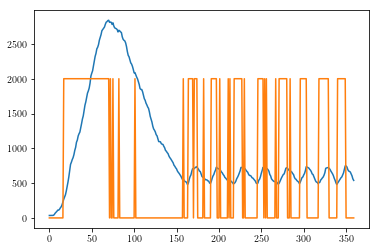

In [131]:
plt.plot(time_vec, C_vec)
plt.plot(time_vec, NPI_vec*2000)

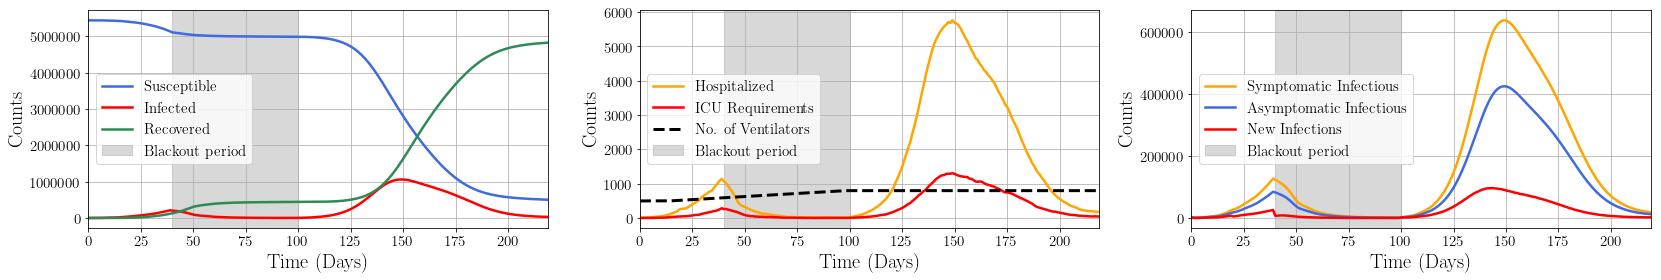

In [18]:
### Plotting

fig, axes = plt.subplots(1,3,figsize=(28,4))

# Plot the S, I, R states
# Plot the states
axes[0].plot(time_vec, S_vec, linewidth=2.5, label='Susceptible', color='royalblue')
axes[0].plot(time_vec, I_vec, linewidth=2.5, label='Infected', color='red')
axes[0].plot(time_vec, R_vec, linewidth=2.5, label='Recovered', color ='seagreen')

# Fill the portion of graph when blackout is on
axes[0].axvspan(t_blackout_on, t_blackout_off, alpha=0.3, label='Blackout period', color='grey')

# Set axis limits
axes[0].set_xlim(time_vec[0], time_vec[-1])
axes[0].grid()

# Set labels
axes[0].set_xlabel('Time (Days)', fontsize=20)
axes[0].set_ylabel('Counts', fontsize=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)

# Set the legend 
axes[0].legend(fontsize=15,loc='center left')

# Plot Hospitalzized and ICU states
# Plot the states
axes[1].plot(time_vec, H_vec, linewidth=2.5, label='Hospitalized', color='orange')
axes[1].plot(time_vec, C_vec, linewidth=2.5, label='ICU Requirements', color='red')
axes[1].plot(time_vec, num_vents, linestyle='--', linewidth=3, label='No. of Ventilators', color='black')

# Fill the portion of graph when blackout is on
axes[1].axvspan(t_blackout_on, t_blackout_off, alpha=0.3, label='Blackout period', color='grey')

# Set axis limits
axes[1].set_xlim(time_vec[0], time_vec[-1])
axes[1].grid()

# Set axis labels
axes[1].set_xlabel('Time (Days)', fontsize=20)
axes[1].set_ylabel('Counts', fontsize=20)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)


# Set the legend 
axes[1].legend(fontsize=15,loc='center left')

# Plot Symptomatic and Asymptomatic Infected Cases
# Plot the states
# axes[2].plot(time_vec, D_vec, linewidth=2.5, label='Dead', color='black')
axes[2].plot(time_vec, Sym_vec, linewidth=2.5, label='Symptomatic Infectious', color='orange')
axes[2].plot(time_vec, Asym_vec, linewidth=2.5, label='Asymptomatic Infectious', color='royalblue')
axes[2].plot(time_vec, NC_vec, linewidth=2.5, label='New Infections', color='red')

# Fill the portion of graph when blackout is on
axes[2].axvspan(t_blackout_on, t_blackout_off, alpha=0.3, label='Blackout period', color='grey')

# Set axis limits
axes[2].set_xlim(time_vec[0], time_vec[-1])
axes[2].grid()

# Set axis labels
axes[2].set_xlabel('Time (Days)', fontsize=20)
axes[2].set_ylabel('Counts', fontsize=20)
axes[2].tick_params(axis='x', labelsize=15)
axes[2].tick_params(axis='y', labelsize=15)

# Set the legend 
axes[2].legend(fontsize=15,loc='center left')

In [179]:
def get_NPI_vec(input_file):

    # Read the JSON file into Python
    with open(input_file,'r') as input_file:
        input_data = json.load(input_file)
    
    # Get the starts and stops of the restrictions
    NPI_start = input_data['parameters']['restrictions_start']
    NPI_end = input_data['parameters']['restrictions_end']

    # Initialize the vector of restrictions
    NPI_vec = np.zeros(len(time_vec))

    # Plotting for the start and stop vectors of equal size
    if (len(NPI_on) == len(NPI_off) ):

        for ind in range(len(NPI_on)):
            NPI_vec[np.arange(NPI_on[ind], NPI_off[ind])] = 1.0

    # Plotting for the start and stop vectors of unequal size
    elif (len(NPI_on) >= len(NPI_off)):

        for ind in range(len(NPI_on)-1):
            NPI_vec[np.arange(NPI_on[ind], NPI_off[ind])] = 1.0

        # Set the values until the end to 1.0
        NPI_vec[NPI_on[-1]:] = 1.0
        
    return NPI_vec

In [183]:
NPI_vec = get_NPI_vec('icu-based.json')

In [150]:
def plotting_time_course(input_file, 
                         plot_municipality=False, muni_string='Banská Bystrica',
                         plot_intermittent=False, switch_measures_on=0.7, switch_measures_off=0.5,
                         asym_ratio=0.4,
                         t_measures_on=None, t_measures_off=None, measures_string='Social distancing',
                         t_ext_measures_on=None, t_ext_measures_off=None,
                         ext_measures_string='Social Distancing of Elderly',
                         t_start_adding_vents=14, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=800,
                         plot_deaths=False):
    """
    Plotting time course of the evolution of states.
    """
    
    # Read the JSON file into Python
    with open(input_file,'r') as input_file:
        input_data = json.load(input_file)

    
    # Get the vector of starts and stops 
    
    
    # Convert the data into a dataframe
    df = pd.DataFrame(input_data["data"])
    
    # Get the dataframe with municipalities
    # Rename the column of municipalities
    df_muni.columns = ['muni_name']
    town_id = df_muni.loc[df_muni['muni_name'] == muni_string].index[0]
    
    # Empty lists of different states individuals
    S_vec = np.zeros(len(df)) # Susceptible
    I_vec = np.zeros(len(df)) # Infected (Symptomatic + Asymptomatic)
    Sym_vec = np.zeros(len(df)) # Symptomatic Individuals
    Asym_vec = np.zeros(len(df)) # Asymptomatic indiviudals 
    R_vec = np.zeros(len(df)) # Recovered
    D_vec = np.zeros(len(df)) # Dead
    H_vec = np.zeros(len(df)) # Hospitalized
    C_vec = np.zeros(len(df)) # Hospitalized in ICU
    NC_vec = np.zeros(len(df)) # Newly infected individuals

    # Get the time vector
    time_vec = np.arange(len(df))

    # Select whether to plot the data for single municipality
    # or the whole country
    if plot_municipality == True:
    
        # Get the vector of states for the single town
        for i in range(len(df)):
            S_vec[i] = df['susceptible'][i][town_id]
            I_vec[i] = df['infected'][i][town_id]
            Sym_vec[i] = (1-asym_ratio) * I_vec[i]
            Asym_vec[i] = asym_ratio * I_vec[i]
            R_vec[i] = df['immune'][i][town_id]
            D_vec[i] = df['dead'][i][town_id]
            H_vec[i] = df['hospitalized'][i][town_id]
            C_vec[i] = df['critical_care'][i][town_id]
            NC_vec[i] = df['new_cases'][i][town_id]
            
    else:
        # Get the vectors of states for the whole country
        for i in range(len(df)):
            S_vec[i] = np.sum(df['susceptible'][i])
            I_vec[i] = np.sum(df['infected'][i])
            Sym_vec[i] = (1-asym_ratio) * I_vec[i]
            Asym_vec[i] = asym_ratio * I_vec[i]
            R_vec[i] = np.sum(df['immune'][i])
            D_vec[i] = np.sum(df['dead'][i])
            H_vec[i] = np.sum(df['hospitalized'][i])
            C_vec[i] = np.sum(df['critical_care'][i])
            NC_vec[i] = np.sum(df['new_cases'][i])
        
    # Get the number of ventilators
    num_vents = get_num_of_ventilators(time_vec, t_start_adding_vents, num_weeks_adding_vents, num_vent_init, num_vent_end)
        
    ### Plotting
    fig, axes = plt.subplots(1,3,figsize=(28,6))

    # Plot the S, I, R states
    axes[0].plot(time_vec, S_vec, linewidth=2.5, label='Susceptible', color='royalblue')
    axes[0].plot(time_vec, I_vec, linewidth=2.5, label='Infected', color='red')
    axes[0].plot(time_vec, R_vec, linewidth=2.5, label='Recovered', color ='seagreen')

    # Plotting measures period
    if t_measures_on is not None and t_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[0].axvspan(t_measures_on, t_measures_off, alpha=0.3, label=measures_string, color='grey')
        
    # Plotting extended measures period
    if t_ext_measures_on is not None and t_ext_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[0].axvspan(t_ext_measures_on, t_ext_measures_off, alpha=0.15, label=ext_measures_string, color='red')
        
    # Plotting start and stop of the control measures
    if plot_intermittent == True:
        NPI_vec = get_NPI_vec('icu-based.json')
        
        # Get the starts and stops of the restrictions
        NPI_start = blackout_data['parameters']['restrictions_start']
        NPI_end = blackout_data['parameters']['restrictions_end']
        
        # Initialize the vector of restrictions
        NPI_vec = np.zeros(len(time_vec))

        # Plotting for the start and stop vectors of equal size
        if (len(NPI_on) == len(NPI_off) ):

            for ind in range(len(NPI_on)):
                NPI_vec[np.arange(NPI_on[ind], NPI_off[ind])] = 1.0

        # Plotting for the start and stop vectors of unequal size
        elif (len(NPI_on) >= len(NPI_off)):

            for ind in range(len(NPI_on)-1):
                NPI_vec[np.arange(NPI_on[ind], NPI_off[ind])] = 1.0

            # Set the values until the end to 1.0
            NPI_vec[NPI_on[-1]:] = 1.0
            
    # Set x-axis limits
    axes[0].set_xlim(time_vec[0], time_vec[-1])
    axes[0].grid()
    
    # Get y-axis limits
    y_lim = axes[0].get_ylim()

    # Set labels
    axes[0].set_xlabel('Time (Days)', fontsize=20)
    axes[0].set_ylabel('Counts', fontsize=20)
    axes[0].tick_params(axis='x', labelsize=15)
    axes[0].tick_params(axis='y', labelsize=15)

    # Set the legend 
    axes[0].legend(fontsize=15,loc='best')

    # Plot Hospitalzized and ICU states
    axes[1].plot(time_vec, H_vec, linewidth=2.5, label='Hospitalized', color='orange')
    axes[1].plot(time_vec, C_vec, linewidth=2.5, label='Hospitalized in ICU', color='red')
    
    if plot_municipality == False:
        axes[1].plot(time_vec, num_vents, linestyle='--', linewidth=3, label='No. of Ventilators', color='black')

    # Plotting measures period
    if t_measures_on is not None and t_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[1].axvspan(t_measures_on, t_measures_off, alpha=0.3, label=measures_string, color='grey')
        
    # Plotting extended measures period
    if t_ext_measures_on is not None and t_ext_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[1].axvspan(t_ext_measures_on, t_ext_measures_off, alpha=0.15, label=ext_measures_string, color='red')

    # Set x-axis limits
    axes[1].set_xlim(time_vec[0], time_vec[-1])
    axes[1].grid()
    
    # Get y-axis limits
    y_lim = axes[1].get_ylim()

    # Set axis labels
    axes[1].set_xlabel('Time (Days)', fontsize=20)
    axes[1].set_ylabel('Counts', fontsize=20)
    axes[1].tick_params(axis='x', labelsize=15)
    axes[1].tick_params(axis='y', labelsize=15)


    # Set the legend 
    axes[1].legend(fontsize=15,loc='best')

    # Plot Symptomatic and Asymptomatic Infected Cases
    # axes[2].plot(time_vec, D_vec, linewidth=2.5, label='Dead', color='black')
    axes[2].plot(time_vec, Sym_vec, linewidth=2.5, label='Symptomatic Infected', color='orange')
    axes[2].plot(time_vec, Asym_vec, linewidth=2.5, label='Asymptomatic Infected', color='royalblue')
    axes[2].plot(time_vec, NC_vec, linewidth=2.5, label='New Infections', color='red')

    # Plotting measures period
    if t_measures_on is not None and t_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[2].axvspan(t_measures_on, t_measures_off, alpha=0.3, label=measures_string, color='grey')

    # Plotting deaths
    if plot_deaths == True:
        axes[2].plot(time_vec, D_vec, linewidth=2.5, label='Cumulative Deaths', color='black')

    # Plotting extended measures period
    if t_ext_measures_on is not None and t_ext_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[2].axvspan(t_ext_measures_on, t_ext_measures_off, alpha=0.15, label=ext_measures_string, color='red')
    
    # Set x-axis limits
    axes[2].set_xlim(time_vec[0], time_vec[-1])
    axes[2].grid()
    
    # Get y-axis limits
    y_lim = axes[2].get_ylim()

    # Set axis labels
    axes[2].set_xlabel('Time (Days)', fontsize=20)
    axes[2].set_ylabel('Counts', fontsize=20)
    axes[2].tick_params(axis='x', labelsize=15)
    axes[2].tick_params(axis='y', labelsize=15)

    # Set the legend 
    axes[2].legend(fontsize=15,loc='best')
        

NameError: name 'NPI_on' is not defined

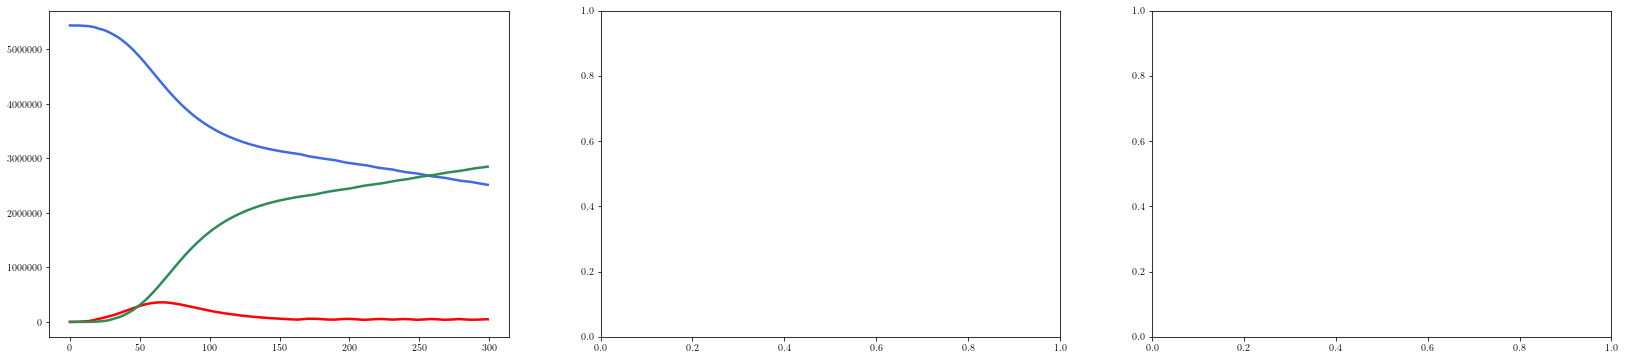

In [151]:
plotting_time_course('icu-based.json',
                     plot_intermittent=True,
                     t_measures_on=None, t_measures_off=None,
                     t_ext_measures_on=None, t_ext_measures_off=None,
                     t_start_adding_vents=14, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=800,
                     plot_deaths=False)

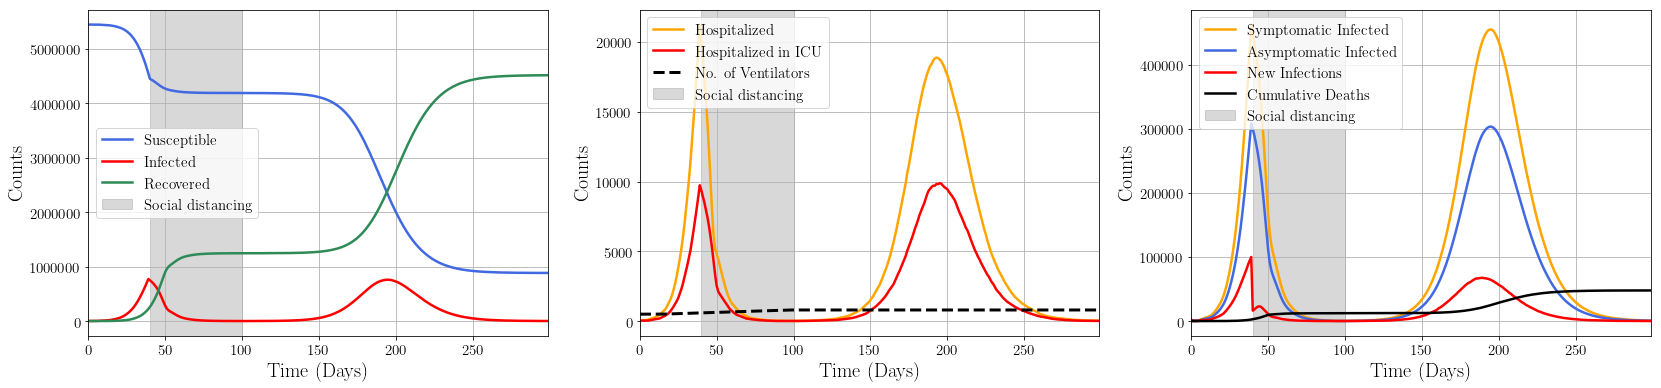

In [136]:
plotting_time_course('blackout.json', 
                     plot_municipality=False,
                     t_measures_on=40, t_measures_off=100,
                     t_start_adding_vents=14, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=800,
                     plot_deaths=True)

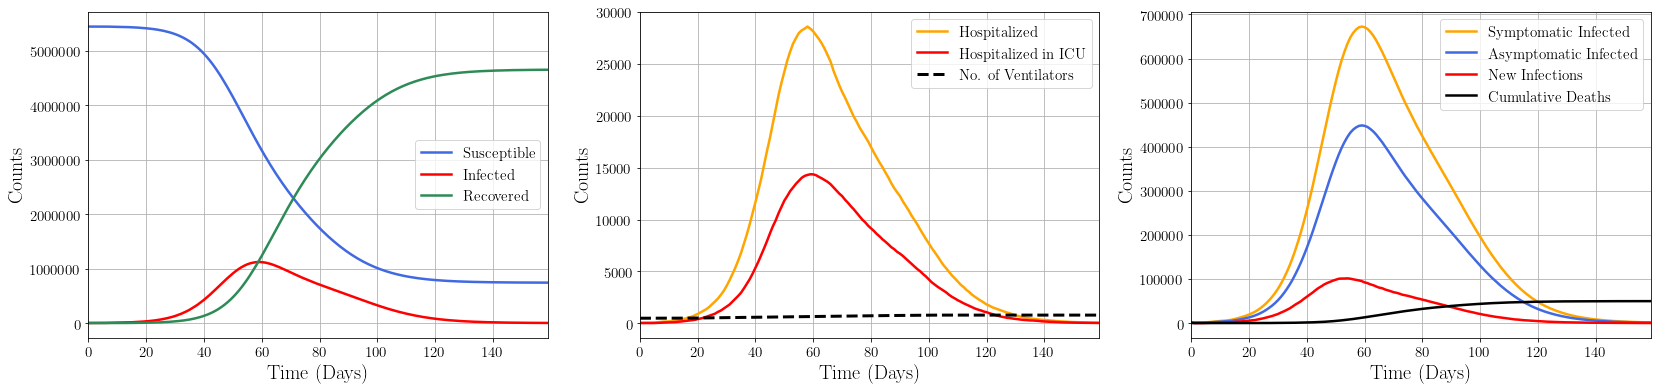

In [21]:
plotting_time_course('business-as-usual.json', asym_ratio, t_measures_on=None, t_measures_off=None,
                     t_start_adding_vents=14, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=800,
                     plot_deaths=True)

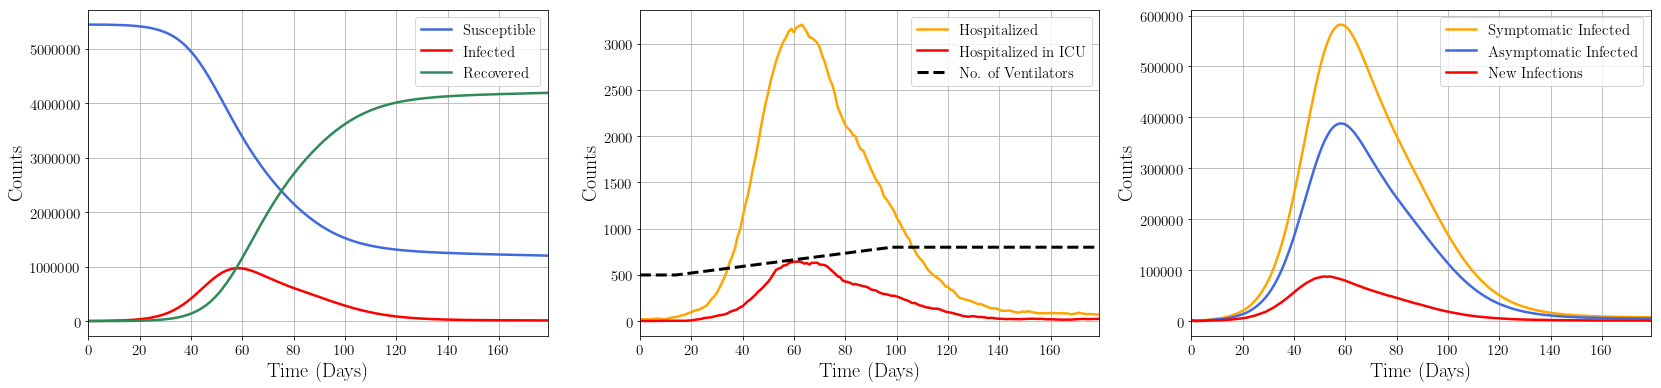

In [22]:
plotting_time_course('business-as-usual-elderly-limited.json', asym_ratio, t_measures_on=None, t_measures_off=None,
                     t_start_adding_vents=14, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=800)

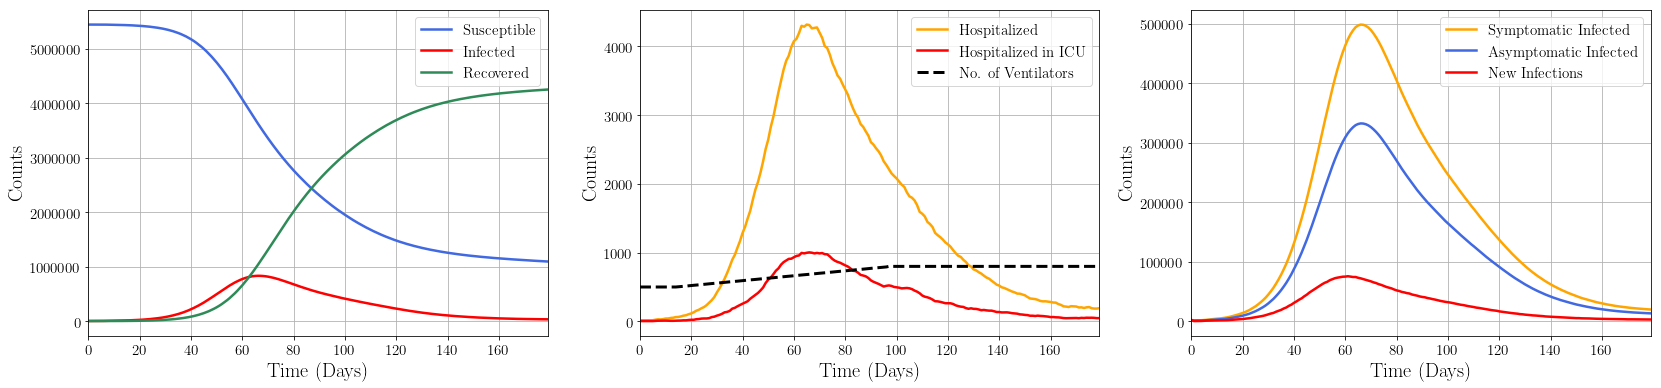

In [23]:
plotting_time_course('restrictions-60.json', asym_ratio, t_measures_on=None, t_measures_off=None,
                     t_start_adding_vents=14, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=800)

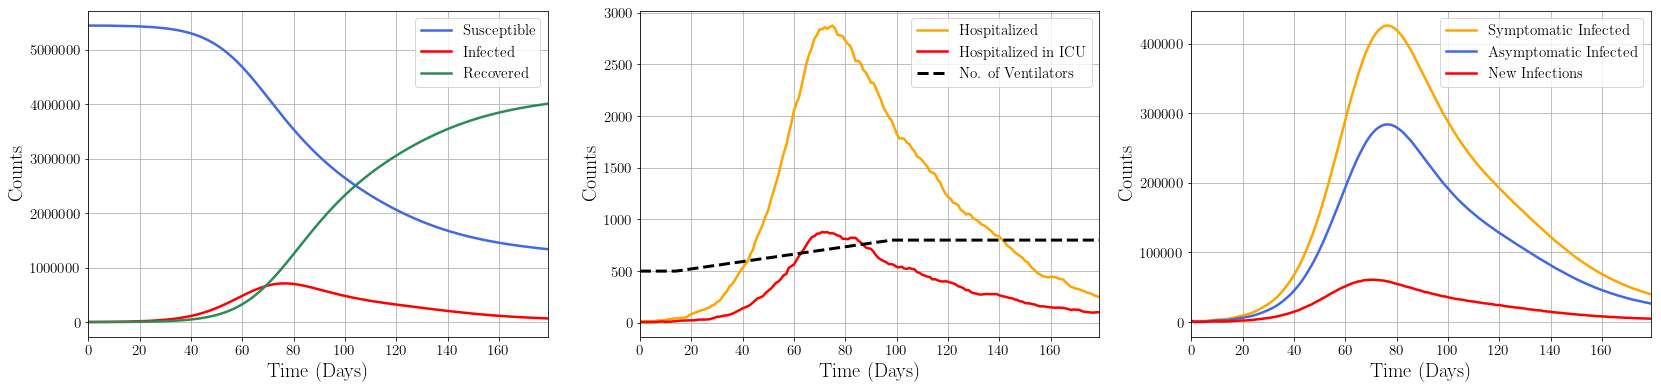

In [24]:
plotting_time_course('restrictions-60-elderly-limited.json', asym_ratio, t_measures_on=None, t_measures_off=None,
                     t_start_adding_vents=14, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=800)

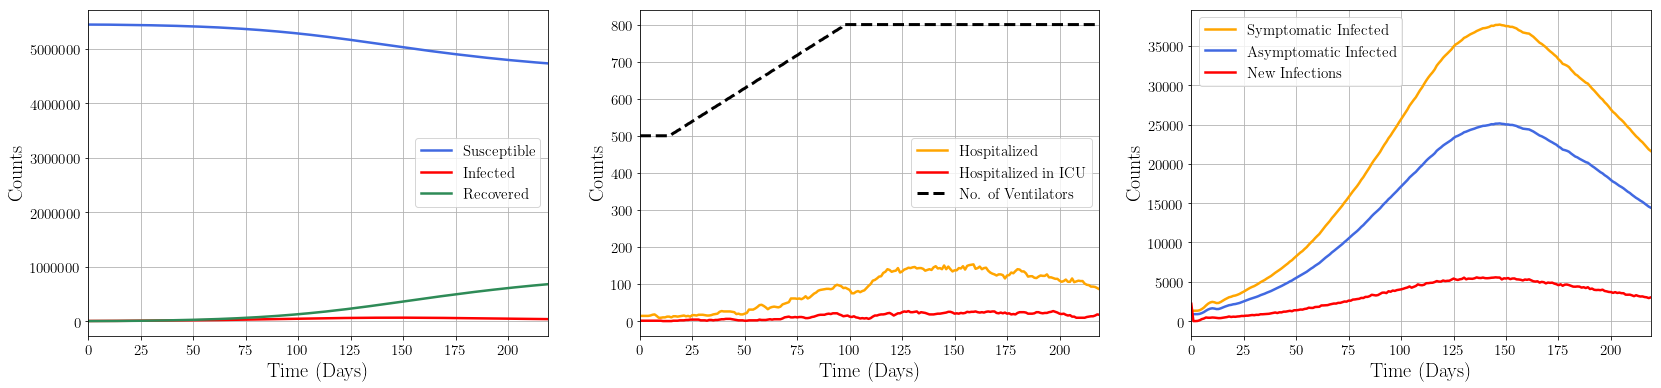

In [25]:
plotting_time_course('restrictions-30-elderly-limited.json', asym_ratio, t_measures_on=None, t_measures_off=None,
                     t_start_adding_vents=14, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=800)

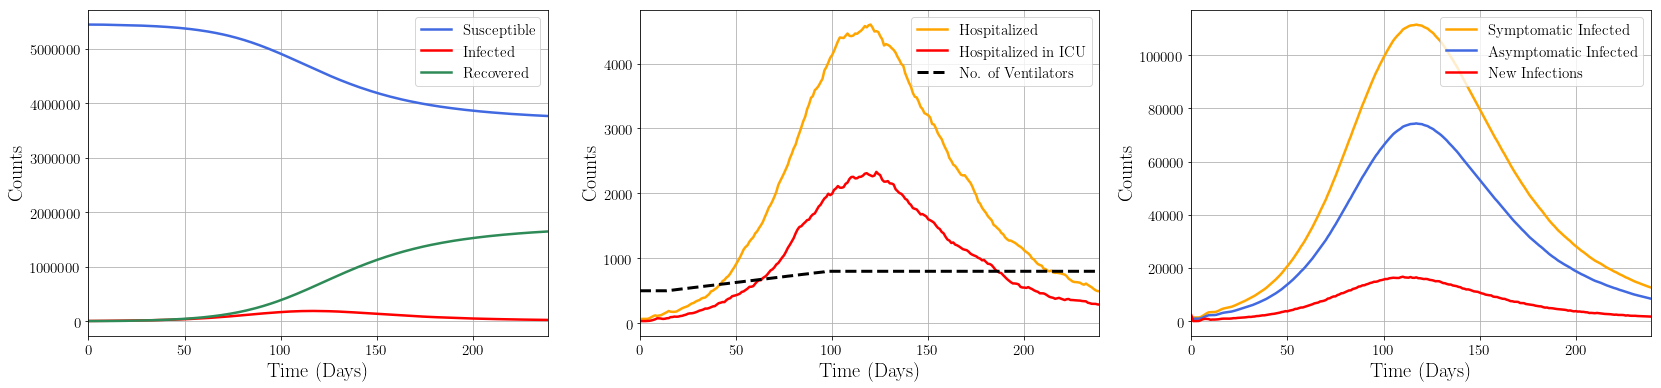

In [26]:
plotting_time_course('current-restrictions.json', asym_ratio, t_measures_on=None, t_measures_off=None,
                     t_start_adding_vents=14, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=800,
                     plot_deaths=False)

What we will present tomorrow: 
1. **Do-nothing scenario**
2. **Restrictions on the movement of elderly (above 60 years):**
    * Everything as usual.
    * Restrict the mobility of the elderly to 20%.
3. **Current scenario:**
    * Google mobility reports estimates to compute the out-of-households contacts within the city (reduced to 52%)
    * OD matrix multiplied by 0.7%
    * Quarantined people have probability of transmission reduced to 20%. Only those with symptoms are quarantined.
    * Every day, there are 1,000 tests made on the people who met the infected. 
      If these tests show that these people have COVID-19, they are also quarantined.
4. **Intermittent social distancing**
    * Google mobility reports estimates to compute the out-of-households contacts within the city (reduced to 52%)
    * OD matrix multiplied by 0.7%
    * Quarantined people have probability of transmission reduced to 20%. Only those with symptoms are quarantined.
    * Every day, there are 1,000 tests made on the people who met the infected. 
      If these tests show that these people have COVID-19, they are also quarantined.
    * If number of ICU cases decreases below 20% of the current ICU capacity, then switch the social distancing OFF.
    * If number of ICU cases increases above 40$ of the current ICU capacity, then switch the social distancing ON.

In [27]:
def plotting_time_course_Slovak(input_file, asym_ratio,
                                t_measures_on=None, t_measures_off=None, measures_string='Doba opatreni',
                                t_ext_measures_on=None, t_ext_measures_off=None,
                                ext_measures_string='Doba izolacie seniorov',
                                t_start_adding_vents=14, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=800,
                                plot_deaths=False):
    """
    Plotting time course of the evolution of states.
    """
    
    # Read the JSON file into Python
    with open(input_file,'r') as input_file:
        input_data = json.load(input_file)

    # Convert the data into a dataframe
    df = pd.DataFrame(input_data["data"])
    
    # Empty lists of different states individuals
    S_vec = np.zeros(len(df)) # Susceptible
    I_vec = np.zeros(len(df)) # Infected (Symptomatic + Asymptomatic)
    Sym_vec = np.zeros(len(df)) # Symptomatic Individuals
    Asym_vec = np.zeros(len(df)) # Asymptomatic indiviudals 
    R_vec = np.zeros(len(df)) # Recovered
    D_vec = np.zeros(len(df)) # Dead
    H_vec = np.zeros(len(df)) # Hospitalized
    C_vec = np.zeros(len(df)) # Hospitalized in ICU
    NC_vec = np.zeros(len(df)) # Newly infected individuals

    # Get the time vector
    time_vec = np.arange(len(df))

    # Get the vectors of states
    for i in range(len(df)):
        S_vec[i] = np.sum(df['susceptible'][i])
        I_vec[i] = np.sum(df['infected'][i])
        Sym_vec[i] = (1-asym_ratio) * I_vec[i]
        Asym_vec[i] = asym_ratio * I_vec[i]
        R_vec[i] = np.sum(df['immune'][i])
        D_vec[i] = np.sum(df['dead'][i])
        H_vec[i] = np.sum(df['hospitalized'][i])
        C_vec[i] = np.sum(df['critical_care'][i])
        NC_vec[i] = np.sum(df['new_cases'][i])
        
    # Get the number of ventilators
    num_vents = get_num_of_ventilators(time_vec, t_start_adding_vents, num_weeks_adding_vents, num_vent_init, num_vent_end)
        
    ### Plotting
    fig, axes = plt.subplots(1,3,figsize=(28,6))

    # Plot the S, I, R states
    # Plot the states
    axes[0].plot(time_vec, S_vec, linewidth=2.5, label='Nachylni', color='royalblue')
    axes[0].plot(time_vec, I_vec, linewidth=2.5, label='Infikovani', color='red')
    axes[0].plot(time_vec, R_vec, linewidth=2.5, label='Zotaveni', color ='seagreen')

    # Plotting measures period
    if t_measures_on is not None and t_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[0].axvspan(t_measures_on, t_measures_off, alpha=0.3, label=measures_string, color='grey')
        
    # Plotting extended measures period
    if t_ext_measures_on is not None and t_ext_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[0].axvspan(t_ext_measures_on, t_ext_measures_off, alpha=0.15, label=ext_measures_string, color='red')

    # Set axis limits
    axes[0].set_xlim(time_vec[0], time_vec[-1])
    axes[0].grid()

    # Set labels
    axes[0].set_xlabel('Cas (Dni)', fontsize=20)
    axes[0].set_ylabel('Pocty', fontsize=20)
    axes[0].tick_params(axis='x', labelsize=15)
    axes[0].tick_params(axis='y', labelsize=15)

    # Set the legend 
    axes[0].legend(fontsize=15,loc='best')

    # Plot Hospitalzized and ICU states
    # Plot the states
    axes[1].plot(time_vec, H_vec, linewidth=2.5, label='Hospitalizovani', color='orange')
    axes[1].plot(time_vec, C_vec, linewidth=2.5, label='Hospitalizovani na JIS', color='red')
    axes[1].plot(time_vec, num_vents, linestyle='--', linewidth=3, label='Pocet ventilatorov', color='black')

    # Plotting measures period
    if t_measures_on is not None and t_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[1].axvspan(t_measures_on, t_measures_off, alpha=0.3, label=measures_string, color='grey')
        
    # Plotting extended measures period
    if t_ext_measures_on is not None and t_ext_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[1].axvspan(t_ext_measures_on, t_ext_measures_off, alpha=0.15, label=ext_measures_string, color='red')

    # Set axis limits
    axes[1].set_xlim(time_vec[0], time_vec[-1])
    axes[1].grid()

    # Set axis labels
    axes[1].set_xlabel('Cas (Dni)', fontsize=20)
    axes[1].set_ylabel('Pocty', fontsize=20)
    axes[1].tick_params(axis='x', labelsize=15)
    axes[1].tick_params(axis='y', labelsize=15)


    # Set the legend 
    axes[1].legend(fontsize=15,loc='best')

    # Plot Symptomatic and Asymptomatic Infected Cases
    # Plot the states
    # axes[2].plot(time_vec, D_vec, linewidth=2.5, label='Dead', color='black')
    axes[2].plot(time_vec, Sym_vec, linewidth=2.5, label='Symptomaticki Infikovani', color='orange')
    axes[2].plot(time_vec, Asym_vec, linewidth=2.5, label='Asymptomaticki Infikovani', color='royalblue')
    axes[2].plot(time_vec, NC_vec, linewidth=2.5, label='Nove Infekcie', color='red')

    # Plotting measures period
    if t_measures_on is not None and t_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[2].axvspan(t_measures_on, t_measures_off, alpha=0.3, label=measures_string, color='grey')

    # Plotting deaths
    if plot_deaths == True:
        axes[2].plot(time_vec, D_vec, linewidth=2.5, label='Kumulativne Umrtia', color='black')

    # Plotting extended measures period
    if t_ext_measures_on is not None and t_ext_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[2].axvspan(t_ext_measures_on, t_ext_measures_off, alpha=0.15, label=ext_measures_string, color='red')
    
    # Set axis limits
    axes[2].set_xlim(time_vec[0], time_vec[-1])
    axes[2].grid()

    # Set axis labels
    axes[2].set_xlabel('Cas (Dni)', fontsize=20)
    axes[2].set_ylabel('Pocet', fontsize=20)
    axes[2].tick_params(axis='x', labelsize=15)
    axes[2].tick_params(axis='y', labelsize=15)

    # Set the legend 
    axes[2].legend(fontsize=15,loc='best')
        

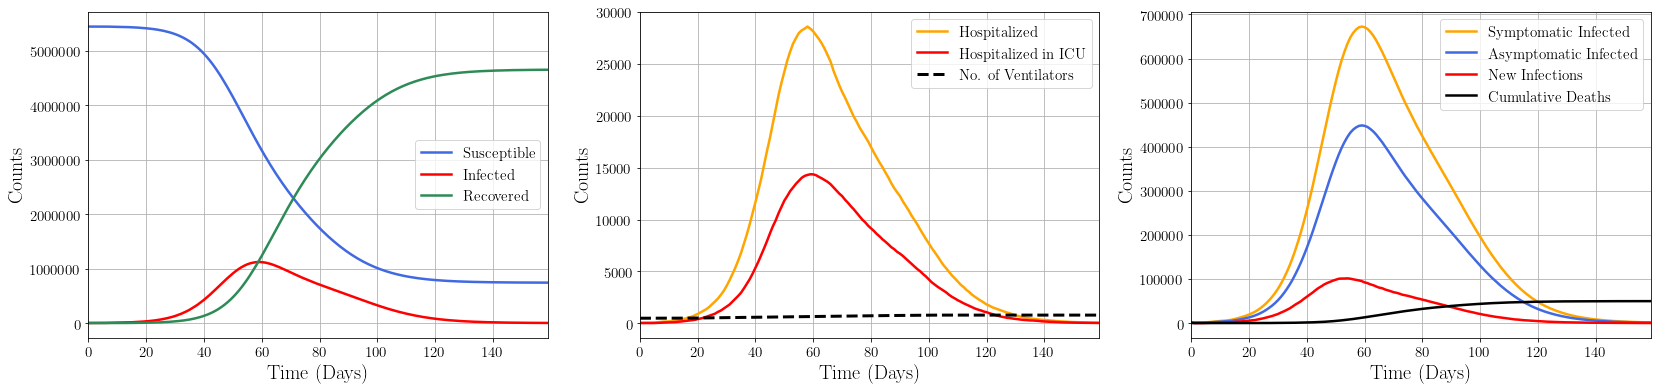

In [28]:
plotting_time_course('business-as-usual.json', asym_ratio, t_measures_on=None, t_measures_off=None,
                     t_start_adding_vents=14, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=800,
                     plot_deaths=True)

Scenario: `quarantene.json`
In this case, we assume:
* Mobility as usual
* Quarantined individuals have reduced infectiousness to 20%
* Quarantine starts 1 day after the start of infectiousness
* 

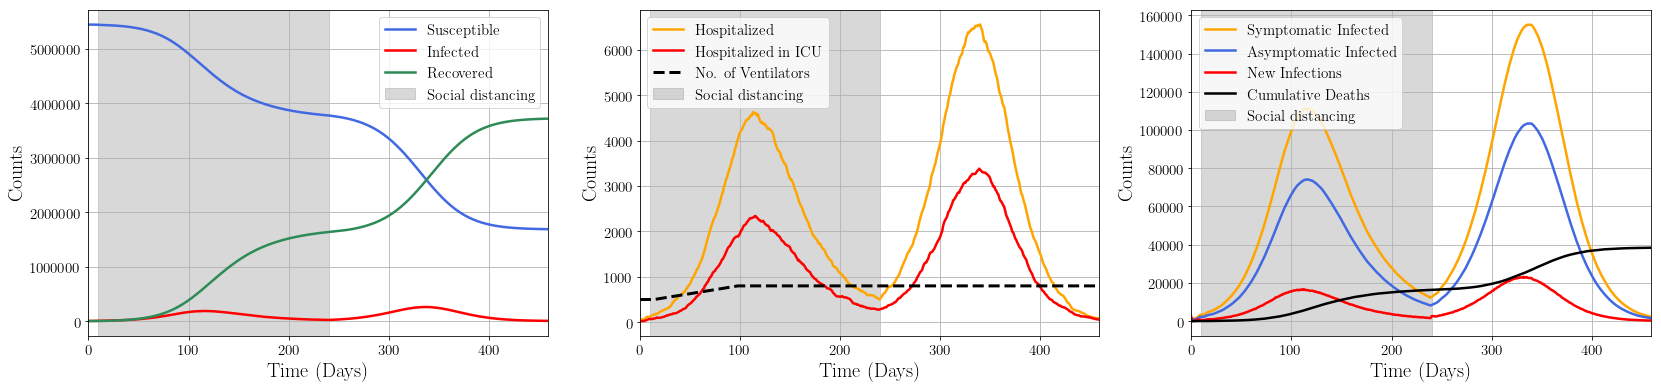

In [32]:
plotting_time_course('double-peak.json', asym_ratio, t_measures_on=10, t_measures_off=240,
                     t_start_adding_vents=14, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=800,
                     plot_deaths=True)

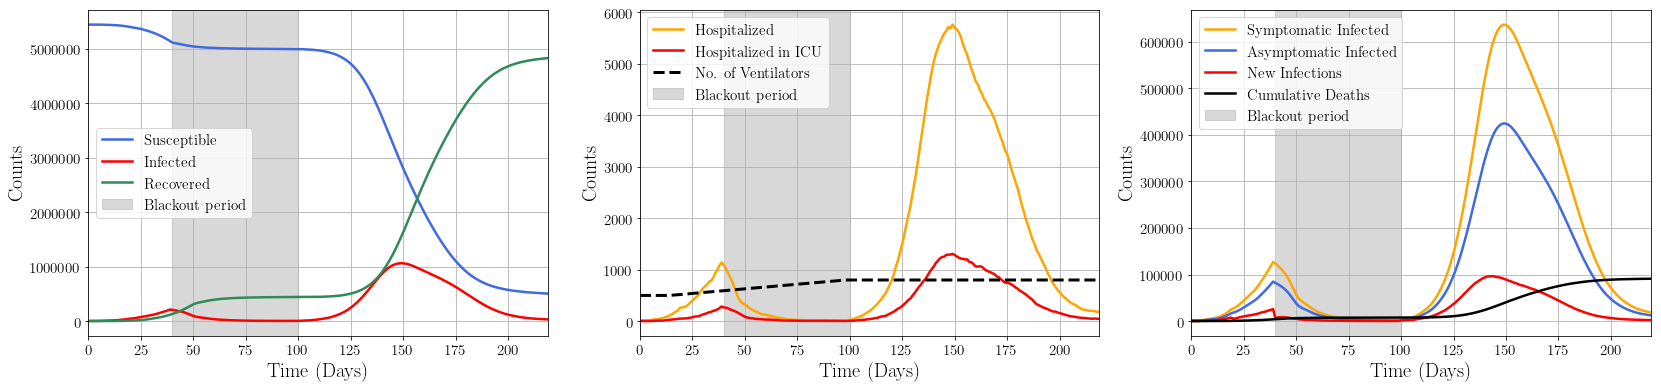

In [30]:
plotting_time_course('blackout.json', asym_ratio, t_measures_on=40, t_measures_off=100,
                     measures_string='Blackout period',
                     t_start_adding_vents=14, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=800,
                     plot_deaths=True)

**Current scenario:**
* Google mobility reports estimates to compute the out-of-households contacts within the city (reduced to 52%)
* OD matrix multiplied by 0.7
* Quarantined people have probability of transmission reduced to 20%. Only those with symptoms are quarantined. Only those who are infectious and symptomatic, after one day of the symptoms, have probability of transmission reduced to 20%.
* Every day, there are 1,500 tests made on the people who met the infected. We compute the probability of catching the infected person num_tests/(num_infected * num_meetings) -> probability that infected is tested. If these tests show that these people have COVID-19, they are also quarantined.

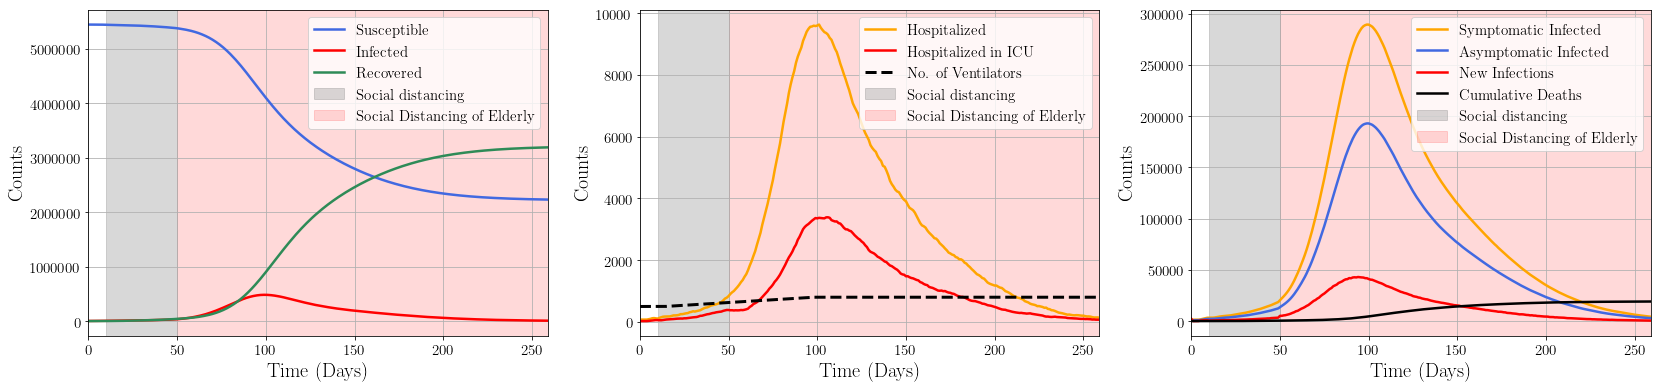

In [33]:
plotting_time_course('elderly-limited.json', asym_ratio, t_measures_on=10, t_measures_off=50,
                            t_ext_measures_on=50, t_ext_measures_off=260,
                     t_start_adding_vents=14, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=800,
                     plot_deaths=True)

**Elderly limited:**
* 10 days nothing (since 16th March, but this can vary)
* After 10 days current restrictions, current scenario occurs
**Current scenario:**
    * Google mobility reports estimates to compute the out-of-households contacts within the city (reduced to 52%)
    * OD matrix multiplied by 0.7
    * Quarantined people have probability of transmission reduced to 20%. Only those with symptoms are quarantined. Only those who are  
      infectious and symptomatic, after one day of the symptoms, have probability of transmission reduced to 20%.
    * Every day, there are 1,500 tests made on the people who met the infected. We compute the probability of catching the infected person 
      num_tests/(num_infected * num_meetings) -> probability that infected is tested. If these tests show that these people have COVID-19, 
      they are also quarantined.
      
* After 50 days from the beginning, switch off the current-restrictions and only keep the elderly-limited (reduced mobility to 20% for people aged 60y)

**ICU-limited**
* Business as usual for the first 10 days
* If ICU capacity is filled to 70%, switch on the following NPI: 
    * Reduce random contacts to 40%
    * No testing, tracing, etc.
* If ICU capacity is filled to 50%, switch OFF the NPI.
* Assuming 1000 ICU/LV

**Blackout**
* Business as usual for the first 40 days
* For next 60 days, switch on the NPI:
    * Reduce the number of random contacts to 5% 
* After 100 days,release the restrictions
